# Panduan Assignment
- Anda adalah seorang Data Scientist dan diminta untuk melakukan analisis data serta membuat pemodelan untuk melakukan prediksi stroke.
- Dataset: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
- Kerjakan  tugas  ini  menggunakan  Google  Colab.  Lakukan  analisis  data untuk menganalisis distribusi data, pengecekan korelasi, dll.- Gunakan algoritma Decision Tree dan Random Forest untuk melakukan prediksi penyakit stroke
- Lakukan  Hyperparameter  Tuning  Pada  model  tersebut  dan  tentukan model  mana  yang  terbaik  berdasarkan  matrik  evaluasi  yang  anda gunakan.


In [ ]:
!pip install phik
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 11.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import phik
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, f1_score

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

## Load Dataset

In [ ]:
# df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df = pd.read_csv('/content/drive/MyDrive/MSIB/assigment/datasets/healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isna().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


In [ ]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


there's anomalies data in column age(min) and column bmi(min)

In [ ]:
df.describe(include='object')

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


anomalies in gender column

## EDA

menampilkan work_type pada category `children` berdasarkan urutan `age` ASC order

In [ ]:
df[df['work_type'] == 'children'].sort_values(by='age')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3295,29955,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0
1614,47350,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
4021,8247,Male,0.16,0,0,No,children,Urban,109.52,13.9,Unknown,0
3618,22877,Male,0.16,0,0,No,children,Urban,114.71,17.4,Unknown,0
3968,41500,Male,0.16,0,0,No,children,Rural,69.79,13.0,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
292,44338,Female,16.00,0,0,No,children,Rural,110.63,19.5,Unknown,0
4018,29453,Male,16.00,0,0,No,children,Rural,91.58,15.8,Unknown,0
2530,45469,Male,16.00,0,0,No,children,Rural,134.23,30.6,Unknown,0
4878,30658,Male,16.00,0,0,No,children,Rural,82.44,32.6,Unknown,0


Mencari work_type atau kategori `children` dibawah 18 tahun yang terjangkit `stroke`

In [ ]:
df[(df['work_type'] == 'children') & df['stroke'] == 1]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
245,49669,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1


saya memutuskan untuk menghapus data dengan work_type category `children` dikarenakan sangat jarang sekali(outliers) terjadi `stroke` pada usia remaja.

In [ ]:
df = df.drop(df[(df['work_type'] == 'children') & df['stroke'] == 1].index)

memastikan apakah data sudah benar-benar di hapus.

In [ ]:
df[(df['work_type'] == 'children') & df['stroke'] == 1]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


menghitung jumlah data dengan _age_ lebih kecil dari 1 tahun

In [ ]:
df[df['age'] < 1 ].sort_values(by='age', ascending=True).shape[0]

43

menghapus data dengan _age_ < 1 tahun

In [ ]:
df = df.drop(df[df['age'] < 1].index)

In [ ]:
df[df['age'] < 1].sort_values(by='age', ascending=True).shape[0]

0

#### Melakukan analysis pada kolomm `Smokin_status` apakah _Unknown_ selalu anak kecil?

In [ ]:
df[df['smoking_status'] == 'Unknown']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
23,64778,Male,82.0,0,1,Yes,Private,Rural,208.30,32.5,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5098,579,Male,9.0,0,0,No,children,Urban,71.88,17.5,Unknown,0
5101,36901,Female,45.0,0,0,Yes,Private,Urban,97.95,24.5,Unknown,0
5103,22127,Female,18.0,0,0,No,Private,Urban,82.85,46.9,Unknown,0
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0


dari hasil analisis diatas, dapat di pastikan bahwa _smoking status_ dengan value `unknown` tidak selalu _children_

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5065 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5065 non-null   int64  
 1   gender             5065 non-null   object 
 2   age                5065 non-null   float64
 3   hypertension       5065 non-null   int64  
 4   heart_disease      5065 non-null   int64  
 5   ever_married       5065 non-null   object 
 6   work_type          5065 non-null   object 
 7   Residence_type     5065 non-null   object 
 8   avg_glucose_level  5065 non-null   float64
 9   bmi                4866 non-null   float64
 10  smoking_status     5065 non-null   object 
 11  stroke             5065 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 514.4+ KB


In [ ]:
# plt.figure(figsize=(10, 6))qEA
# sns.histplot(data=df, x='age', hue='stroke', bins=25, kde=True)

In [ ]:
# plt.figure(figsize=(10, 6))
# sns.countplot(data=df, x='hypertension', hue='stroke')

In [ ]:
# plt.figure(figsize=(10, 6))
# sns.countplot(data=df, x='heart_disease', hue='stroke')

In [ ]:
# plt.figure(figsize=(10, 6))
# sns.histplot(data=df, x='avg_glucose_level', hue='stroke', bins=25, kde=True)

In [ ]:
# plt.figure(figsize=(10, 6))
# sns.histplot(data=df, x='bmi', hue='stroke', bins=25, kde=True)

In [ ]:
# plt.figure(figsize=(10, 6))
# sns.histplot(data=df, x='smoking_status', hue='stroke', bins=25, kde=True)

In [ ]:
# for i in df.select_dtypes('object').columns:
#   sns.countplot(data=df, x=i, hue='stroke')
#   plt.title(i)
#   plt.show()

#### Checking Correlation

In [ ]:
object_corr = df.drop(['id'], axis=1).phik_matrix(interval_cols=['age', 'avg_glucose_level', 'bmi'])
object_corr

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,1.000000,0.122667,0.007042,0.051119,0.015151,0.071462,0.000000,0.103920,0.171438,0.073386,0.000000
age,0.122667,1.000000,0.366453,0.387482,0.921498,0.831035,0.032372,0.312814,0.494340,0.494355,0.374112
hypertension,0.007042,0.366453,1.000000,0.164659,0.249246,0.128620,0.000000,0.268471,0.168632,0.207257,0.196815
heart_disease,0.051119,0.387482,0.164659,1.000000,0.173329,0.091586,0.000000,0.231979,0.091073,0.133459,0.206949
ever_married,0.015151,0.921498,0.249246,0.173329,1.000000,0.457640,0.000000,0.229911,0.408259,0.486630,0.168206
work_type,0.071462,0.831035,0.128620,0.091586,0.457640,1.000000,0.009544,0.158516,0.501120,0.349174,0.078674
Residence_type,0.000000,0.032372,0.000000,0.000000,0.000000,0.009544,1.000000,0.022015,0.000000,0.033019,0.007320
avg_glucose_level,0.103920,0.312814,0.268471,0.231979,0.229911,0.158516,0.022015,1.000000,0.147886,0.121788,0.195444
bmi,0.171438,0.494340,0.168632,0.091073,0.408259,0.501120,0.000000,0.147886,1.000000,0.318520,0.051287
smoking_status,0.073386,0.494355,0.207257,0.133459,0.486630,0.349174,0.033019,0.121788,0.318520,1.000000,0.108831


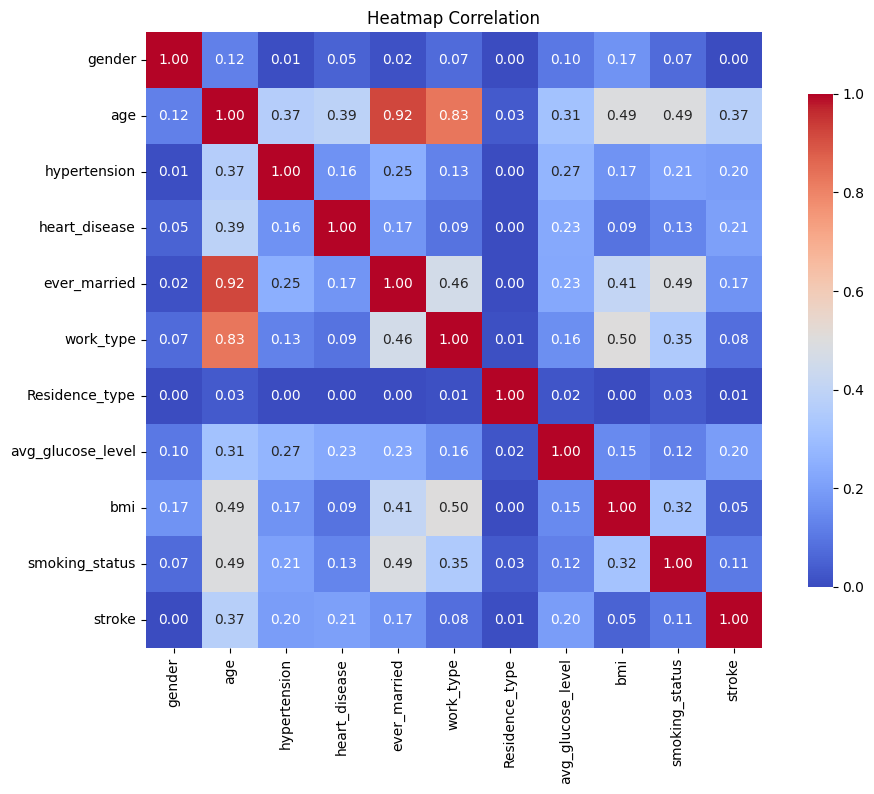

In [ ]:
plt.figure(figsize=(12, 8))

sns.heatmap(object_corr, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, cbar_kws={"shrink": .8})

plt.title('Heatmap Correlation')
plt.show()

## Feature Engineering

In [ ]:
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
y_train.value_counts(normalize=True)

,proportion
stroke,
0,0.951135
1,0.048865


#### Imputer

In [ ]:
knn_imputer = KNNImputer()

#### Scaling

In [ ]:
scaler = StandardScaler()

#### Encode

In [ ]:
numeric = ['age', 'bmi', 'avg_glucose_level']

nominal = ['gender', 'ever_married', 'work_type',
           'Residence_type', 'smoking_status']

#### Pipeline

In [ ]:
numeric_pipeline = Pipeline([
  ('imputer', knn_imputer),
  ('scaler', scaler)])

nominal_pipeline = Pipeline([
  ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocess = ColumnTransformer(
  transformers=[
    ('numerical', numeric_pipeline, numeric),
    ('nominal',  nominal_pipeline, nominal)
],
remainder='drop')

In [ ]:
preprocess

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'bmi', 'avg_glucose_level']),
                                ('nominal',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['gender', 'ever_married', 'work_type',
                                  'Residence_type', 'smoking_status'])])

In [ ]:
hellnah = preprocess.fit_transform(X_train)
pd.DataFrame(hellnah, columns=preprocess.get_feature_names_out())

,numerical__age,numerical__bmi,numerical__avg_glucose_level,nominal__gender_Female,nominal__gender_Male,nominal__gender_Other,nominal__ever_married_No,nominal__ever_married_Yes,nominal__work_type_Govt_job,nominal__work_type_Never_worked,nominal__work_type_Private,nominal__work_type_Self-employed,nominal__work_type_children,nominal__Residence_type_Rural,nominal__Residence_type_Urban,nominal__smoking_status_Unknown,nominal__smoking_status_formerly smoked,nominal__smoking_status_never smoked,nominal__smoking_status_smokes
0,0.510861,0.405235,-0.911735,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.119894,1.946531,-0.302927,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-1.471512,-0.754030,0.777642,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1.411940,-0.161224,-0.002256,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,-1.904030,-1.333663,-0.349708,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4047,0.826238,0.629184,-0.645546,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4048,-0.930865,1.366898,-0.594812,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4049,-1.561620,-1.662999,-1.011226,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4050,0.015268,0.708225,-0.259441,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


## Modeling

In [ ]:
smote  = SMOTE(random_state=42)

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)

In [ ]:
# Menggunakan ImbPipeline dari imbalanced-learn untuk SMOTE
pipe_decision_tree = ImbPipeline([
    ('prep', preprocess),
    ('smote', SMOTE(random_state=21)),  # Menggunakan SMOTE di ImbPipeline
    ('decision_tree', decision_tree)
])

pipe_random_forest = ImbPipeline([
    ('prep', preprocess),
    ('smote', SMOTE(random_state=21)),  # Menggunakan SMOTE di ImbPipeline
    ('random_forest', random_forest)
])

# Parameter grid untuk hyperparameter tuning pada Decision Tree
param_grid_decision_tree = {
    'decision_tree__max_depth': [None, 10, 20, 30],
    'decision_tree__min_samples_split': [2, 5, 10],
    'decision_tree__min_samples_leaf': [1, 2, 4]
}

# Parameter grid untuk hyperparameter tuning pada Random Forest
param_grid_random_forest = {
    'random_forest__n_estimators': [50, 100, 200],
    'random_forest__max_depth': [None, 10, 20, 30],
    'random_forest__min_samples_split': [2, 5, 10],
    'random_forest__min_samples_leaf': [1, 2, 4],
    'random_forest__max_features': ['auto', 'sqrt', 'log2']
}

In [ ]:
param_grid_decision_tree = {
    'decision_tree__max_depth': [None, 10, 20, 30],
    'decision_tree__min_samples_split': [2, 5, 10],
    'decision_tree__min_samples_leaf': [1, 2, 4]
}

# Parameter grid untuk hyperparameter tuning pada Random Forest
param_grid_random_forest = {
    'random_forest__n_estimators': [50, 100, 200],
    'random_forest__max_depth': [None, 10, 20, 30],
    'random_forest__min_samples_split': [2, 5, 10],
    'random_forest__min_samples_leaf': [1, 2, 4],
    'random_forest__max_features': ['auto', 'sqrt', 'log2']
}

### Cross-Validation

In [ ]:
# GridSearchCV untuk Decision Tree
grid_search_decision_tree = GridSearchCV(pipe_decision_tree, param_grid_decision_tree,
                                         cv=5, scoring='precision', n_jobs=-1)
grid_search_decision_tree.fit(X_train, y_train)

# GridSearchCV untuk Random Forest
grid_search_random_forest = GridSearchCV(pipe_random_forest, param_grid_random_forest,
                                         cv=5, scoring='precision', n_jobs=-1)
grid_search_random_forest.fit(X_train, y_train)

# Menampilkan hasil terbaik untuk Decision Tree
print("Best parameters for Decision Tree:", grid_search_decision_tree.best_params_)
print("Best precision score for Decision Tree:", grid_search_decision_tree.best_score_)

# Menampilkan hasil terbaik untuk Random Forest
print("Best parameters for Random Forest:", grid_search_random_forest.best_params_)
print("Best precision score for Random Forest:", grid_search_random_forest.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 333, in fit
    self._final_estimator.fit(Xt, yt, **last_step_params["fit"])
  File "/usr/local/li

Best parameters for Decision Tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_leaf': 2, 'decision_tree__min_samples_split': 10}
Best precision score for Decision Tree: 0.1534601867509742
Best parameters for Random Forest: {'random_forest__max_depth': 10, 'random_forest__max_features': 'sqrt', 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 10, 'random_forest__n_estimators': 50}
Best precision score for Random Forest: 0.16955139868597838


In [ ]:
best_decision_tree = grid_search_decision_tree.best_estimator_
best_random_forest = grid_search_random_forest.best_estimator_

# Prediksi pada test set menggunakan model terbaik
y_pred_dt = best_decision_tree.predict(X_test)
y_pred_rf = best_random_forest.predict(X_test)

# Menghitung precision dan F1 score pada test set
precision_dt = precision_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

precision_rf = precision_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Decision Tree precision on test set:", precision_dt)
print("Decision Tree F1 score on test set:", f1_dt)

print("Random Forest precision on test set:", precision_rf)
print("Random Forest F1 score on test set:", f1_rf)

Decision Tree precision on test set: 0.1187214611872146
Decision Tree F1 score on test set: 0.19402985074626866
Random Forest precision on test set: 0.10897435897435898
Random Forest F1 score on test set: 0.16585365853658537


In [ ]:
# Cross-validation untuk Decision Tree dan Random Forest
cv_decision_tree = cross_val_score(
    best_decision_tree, X_train, y_train, cv=5, scoring='precision')
cv_random_forest = cross_val_score(
    best_random_forest, X_train, y_train, cv=5, scoring='precision')

# Menampilkan hasil cross-validation
print("Cross-validation precision score for Decision Tree:", cv_decision_tree.mean())
print("Cross-validation precision score for Random Forest:", cv_random_forest.mean())

# Mengambil model terbaik setelah GridSearch
best_decision_tree = grid_search_decision_tree.best_estimator_
best_random_forest = grid_search_random_forest.best_estimator_

# Prediksi pada test set menggunakan model terbaik
y_pred_dt = best_decision_tree.predict(X_test)
y_pred_rf = best_random_forest.predict(X_test)

# Menghitung precision dan F1 score pada test set
precision_dt = precision_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

precision_rf = precision_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Decision Tree precision on test set:", precision_dt)
print("Decision Tree F1 score on test set:", f1_dt)

print("Random Forest precision on test set:", precision_rf)
print("Random Forest F1 score on test set:", f1_rf)



Cross-validation precision score for Decision Tree: 0.1534601867509742
Cross-validation precision score for Random Forest: 0.16955139868597838
Decision Tree precision on test set: 0.1187214611872146
Decision Tree F1 score on test set: 0.19402985074626866
Random Forest precision on test set: 0.10897435897435898
Random Forest F1 score on test set: 0.16585365853658537


In [ ]:
# Cross-validation untuk Decision Tree dan Random Forest
cv_decision_tree = cross_val_score(
    best_decision_tree, X_train, y_train, cv=5, scoring='precision')
cv_random_forest = cross_val_score(
    best_random_forest, X_train, y_train, cv=5, scoring='precision')

# Menampilkan hasil cross-validation
print("Cross-validation precision score for Decision Tree:", cv_decision_tree.mean())
print("Cross-validation precision score for Random Forest:", cv_random_forest.mean())

Cross-validation precision score for Decision Tree: 0.1534601867509742
Cross-validation precision score for Random Forest: 0.16955139868597838


In [ ]:
# y_pred_prob = pipe_random_forest.predict_proba(X_test)[:, 1]
# y_pred_prob.mean()
# # y_pred_threshold = (y_pred_prob > 0.).astype(int)  # Mengubah threshold menjadi 0.2

# # # Evaluasi precision dan F1 dengan threshold yang disesuaikan
# # precision_test = precision_score(y_test, y_pred_threshold)
# # f1_test = f1_score(y_test, y_pred_threshold)

# # print("Precision on test set with threshold 0.2:", precision_test)
# # print("F1 score on test set with threshold 0.2:", f1_test)

### Hyperparameter Tuning

In [ ]:
smote = SMOTE(random_state=42)

In [ ]:
# Parameter grid untuk Decision Tree
param_grid_decision_tree = {
    'decision_tree__max_depth': [None, 10, 20, 30],
    'decision_tree__min_samples_split': [2, 5, 10],
    'decision_tree__min_samples_leaf': [1, 2, 4]
}

# Parameter grid untuk Random Forest
param_grid_random_forest = {
    'random_forest__n_estimators': [50, 100, 200],
    'random_forest__max_depth': [None, 10, 20, 30],
    'random_forest__min_samples_split': [2, 5, 10],
    'random_forest__min_samples_leaf': [1, 2, 4],
    'random_forest__max_features': ['auto', 'sqrt', 'log2']
}

In [ ]:
pipe_decision_tree_smote = Pipeline([
    ('prep', preprocess),
    ('smote', smote),
    ('decision_tree', DecisionTreeClassifier())
])

# Pipeline dengan SMOTE untuk Random Forest
pipe_random_forest_smote = Pipeline([
    ('prep', preprocess),
    ('smote', smote),
    ('random_forest', RandomForestClassifier(class_weight=None))
])

In [ ]:
# GridSearchCV untuk Decision Tree dengan SMOTE
grid_search_decision_tree = GridSearchCV(pipe_decision_tree_smote, param_grid_decision_tree,
                                          cv=5, scoring='precision', n_jobs=-1)
grid_search_decision_tree.fit(X_train, y_train)

# GridSearchCV untuk Random Forest dengan SMOTE
grid_search_random_forest = GridSearchCV(pipe_random_forest_smote, param_grid_random_forest,
                                          cv=5, scoring='precision', n_jobs=-1)
grid_search_random_forest.fit(X_train, y_train)

ValueError: 
All the 180 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 386, in _fit
    self._validate_steps()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 256, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE(random_state=42)' (type <class 'imblearn.over_sampling._smote.base.SMOTE'>) doesn't


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Assuming df is your dataset
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=21)

# Numeric and nominal columns
numeric = ['age', 'bmi', 'avg_glucose_level']
nominal = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Pipelines for numeric and nominal data
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

nominal_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ('numerical', numeric_pipeline, numeric),
        ('nominal', nominal_pipeline, nominal)
    ]
)

# SMOTE for balancing
smote = SMOTE(random_state=21)

# Models
decision_tree = DecisionTreeClassifier(random_state=21)
random_forest = RandomForestClassifier(random_state=21)

# Pipelines with SMOTE
pipe_decision_tree_smote = ImbPipeline([
    ('prep', preprocess),
    ('smote', smote),
    ('decision_tree', decision_tree)
])

pipe_random_forest_smote = ImbPipeline([
    ('prep', preprocess),
    ('smote', smote),
    ('random_forest', random_forest)
])

# Parameter grids for RandomizedSearchCV
param_grid_decision_tree = {
    'decision_tree__max_depth': [None, 10, 20],
    'decision_tree__min_samples_split': [2, 5],
    'decision_tree__min_samples_leaf': [1, 2]
}

param_grid_random_forest = {
    'random_forest__n_estimators': [50, 100],
    'random_forest__max_depth': [None, 10],
    'random_forest__min_samples_split': [2],
    'random_forest__min_samples_leaf': [1],
    'random_forest__max_features': ['sqrt']
}

# RandomizedSearchCV for Decision Tree
random_search_decision_tree = RandomizedSearchCV(pipe_decision_tree_smote,
                                                 param_distributions=param_grid_decision_tree,
                                                 n_iter=20,  # Reduced iterations for faster tuning
                                                 cv=5,
                                                 scoring='precision',
                                                 random_state=42)
random_search_decision_tree.fit(X_train, y_train)

# RandomizedSearchCV for Random Forest
random_search_random_forest = RandomizedSearchCV(pipe_random_forest_smote,
                                                 param_distributions=param_grid_random_forest,
                                                 n_iter=20,  # Reduced iterations for faster tuning
                                                 cv=5,
                                                 scoring='precision',
                                                 random_state=42)
random_search_random_forest.fit(X_train, y_train)

# Evaluation on test set
y_pred_dt = random_search_decision_tree.best_estimator_.predict(X_test)
y_pred_rf = random_search_random_forest.best_estimator_.predict(X_test)

# Confusion matrices and classification reports
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrices
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test, y_pred_dt))

print("Confusion Matrix for Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))


NameError: name 'df' is not defined